## 2. Chargement et Exploration des Données <a name="2-chargement"></a>

In [1]:
# Installation des dépendances
!pip install pandas numpy scikit-learn matplotlib seaborn tqdm lightgbm xgboost scipy -q

In [ ]:
import json
import os
import math
import re
import warnings
from datetime import datetime
from urllib.parse import urlparse
from collections import Counter
from typing import Dict, List, Any, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, average_precision_score, f1_score,
    accuracy_score, precision_score, recall_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, pointbiserialr

import lightgbm as lgb
import xgboost as xgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

print("Bibliothèques importées!")

In [6]:
def list_json_files(directory: str) -> List[str]:
    """Liste tous les fichiers JSON dans un répertoire"""
    json_files = []
    if not os.path.exists(directory):
        print(f"Le répertoire {directory} n'existe pas!")
        return json_files
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

benign_files = list_json_files(BENIGN_PATH)
malicious_files = list_json_files(MALICIOUS_PATH)

print(f"Fichiers bénins: {len(benign_files):,}")
print(f"Fichiers malveillants: {len(malicious_files):,}")
print(f"Total: {len(benign_files) + len(malicious_files):,}")

Fichiers bénins: 51,997
Fichiers malveillants: 50,000
Total: 101,997


## 3. Extraction des Features BRUTES <a name="3-extraction"></a>

### 3.1 Extracteur de Features (SANS listes arbitraires)

On extrait d'abord les valeurs BRUTES (TLD, SSL issuer, etc.) sans les catégoriser. L'analyse statistique viendra APRÈS.

In [7]:
class RawFeatureExtractor:
    """
    Extracteur de features BRUTES sans aucune catégorisation a priori.
    Les catégories (TLD risqués, SSL issuers) seront déterminées par l'analyse statistique.
    """
    
    # FEATURES À EXCLURE (Data Leakage)
    LEAKAGE_FIELDS = ['content_status', 'dns_status', 'gsb_verdict']
    
    def __init__(self):
        self.vowels = set('aeiouAEIOU')
        
    @staticmethod
    def safe_get(data: dict, *keys, default=None):
        """Accès sécurisé aux clés imbriquées"""
        result = data
        for key in keys:
            if isinstance(result, dict):
                result = result.get(key, default)
            else:
                return default
        return result if result is not None else default
    
    def calculate_entropy(self, s: str) -> float:
        """Calcule l'entropie de Shannon"""
        if not s:
            return 0.0
        prob = [float(s.count(c)) / len(s) for c in set(s)]
        return -sum([p * math.log2(p) for p in prob if p > 0])
    
    def extract_url_features(self, data: dict) -> dict:
        """Features URL"""
        features = {}
        url = data.get('url', '')
        
        try:
            parsed = urlparse(url)
        except:
            parsed = None
        
        metadata = data.get('metadata', {})
        rd = metadata.get('rd', '')
        fqdn = metadata.get('fqdn', '')
        tld = metadata.get('tld', '')
        
        # Valeurs BRUTES pour analyse statistique ultérieure
        features['tld_raw'] = tld.lower() if tld else ''
        
        # Features numériques
        features['url_length'] = len(url)
        features['path_length'] = len(parsed.path) if parsed else 0
        features['query_length'] = len(parsed.query) if parsed else 0
        
        domain_no_tld = rd.split('.')[0] if rd and '.' in rd else rd
        features['domain_length'] = len(domain_no_tld)
        features['fqdn_length'] = len(fqdn)
        
        # Entropie
        features['domain_entropy'] = self.calculate_entropy(domain_no_tld)
        features['fqdn_entropy'] = self.calculate_entropy(fqdn)
        
        # Consonnes/Voyelles
        vowels = sum(1 for c in domain_no_tld.lower() if c in 'aeiou')
        consonants = sum(1 for c in domain_no_tld.lower() if c.isalpha() and c not in 'aeiou')
        features['domain_vowel_count'] = vowels
        features['domain_consonant_count'] = consonants
        features['domain_cv_ratio'] = consonants / (vowels + 1)
        
        # Sous-domaines
        subdomain_depth = fqdn.count('.') - 1 if fqdn and '.' in rd else 0
        features['subdomain_depth'] = max(0, subdomain_depth)
        features['has_subdomain'] = 1 if data.get('has_subdomain') else 0
        
        # Caractères spéciaux
        features['url_digit_count'] = sum(c.isdigit() for c in url)
        features['domain_digit_count'] = sum(c.isdigit() for c in domain_no_tld)
        features['url_hyphen_count'] = url.count('-')
        features['url_at_count'] = url.count('@')
        
        # TLD features
        features['tld_length'] = len(tld)
        tld_index = self.safe_get(metadata, 'tld_index', 'tld_index', default='0')
        try:
            features['tld_risk_index'] = float(tld_index)
        except:
            features['tld_risk_index'] = 0.0
        
        # IP dans URL
        ip_pattern = r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'
        features['has_ip_in_url'] = 1 if re.search(ip_pattern, url) else 0
        
        # Path
        path = parsed.path if parsed else ''
        features['path_depth'] = path.count('/') - 1 if path else 0
        features['has_path'] = 1 if data.get('has_path') else 0
        
        # HTTPS
        features['is_https'] = 1 if url.startswith('https') else 0
        
        return features
    
    def extract_dns_features(self, data: dict) -> dict:
        """Features DNS"""
        features = {}
        host_info = data.get('host_info', {})
        
        dns_types = ['a', 'aaaa', 'ns', 'txt', 'soa', 'mx']
        for dns_type in dns_types:
            dns_data = host_info.get(dns_type, {})
            answers = dns_data.get('answers', [])
            features[f'dns_{dns_type}_count'] = len(answers) if isinstance(answers, list) else 0
        
        # DMARC
        dmarc = host_info.get('dmarc', {})
        features['dmarc_exists'] = 1 if dmarc.get('status') == 'NOERROR' else 0
        
        # Total DNS
        features['dns_total_records'] = sum(
            features.get(f'dns_{t}_count', 0) for t in dns_types
        )
        
        # GeoIP
        maxmind = host_info.get('maxmind', [])
        if maxmind and len(maxmind) > 0:
            mm = maxmind[0].get('answers', {})
            features['asn_code'] = mm.get('asn_code', 0)
            features['country_code_raw'] = mm.get('cc_code', 'XX')
        else:
            features['asn_code'] = 0
            features['country_code_raw'] = 'XX'
        
        return features
    
    def extract_ssl_features(self, data: dict) -> dict:
        """Features SSL - Valeurs BRUTES"""
        features = {}
        ssl = self.safe_get(data, 'host_info', 'ssl', default={})
        
        features['ssl_is_valid'] = 1 if ssl.get('is_valid_cert') else 0
        features['ssl_exists'] = 1 if ssl.get('msg') == 'success' else 0
        
        # Émetteur BRUT (sera analysé statistiquement)
        issuer = ssl.get('issuer', '')
        features['ssl_issuer_raw'] = issuer.lower() if issuer else ''
        
        # Durée de validité
        valid_from = ssl.get('valid_from', '')
        valid_until = ssl.get('valid_until', '')
        
        if valid_from and valid_until:
            try:
                vf = datetime.strptime(valid_from, '%Y-%m-%d')
                vu = datetime.strptime(valid_until, '%Y-%m-%d')
                features['ssl_validity_days'] = (vu - vf).days
            except:
                features['ssl_validity_days'] = 0
        else:
            features['ssl_validity_days'] = 0
        
        # Wildcard
        subjects = ssl.get('subject', [])
        features['ssl_subjects_count'] = len(subjects) if isinstance(subjects, list) else 0
        features['ssl_is_wildcard'] = 1 if any('*' in str(s) for s in subjects) else 0
        
        return features
    
    def extract_wayback_features(self, data: dict) -> dict:
        """Features Wayback Machine"""
        features = {}
        wayback = self.safe_get(data, 'additional', 'rd', 'wayback_info', default=None)
        
        if wayback:
            features['has_wayback_history'] = 1
            first_ts = wayback.get('first_ts', '')
            
            if first_ts and len(first_ts) >= 8:
                try:
                    first_date = datetime.strptime(first_ts[:8], '%Y%m%d')
                    age_days = (datetime.now() - first_date).days
                    features['domain_age_days'] = age_days
                except:
                    features['domain_age_days'] = 0
            else:
                features['domain_age_days'] = 0
            
            years = wayback.get('years', {})
            features['wayback_years_active'] = len(years) if isinstance(years, dict) else 0
        else:
            features['has_wayback_history'] = 0
            features['domain_age_days'] = 0
            features['wayback_years_active'] = 0
        
        return features
    
    def extract_content_features(self, data: dict) -> dict:
        """Features Contenu ()"""
        features = {}
        content_info = data.get('content_info', {})
        
        # Nombre de ressources
        responses = content_info.get('responses', [])
        features['response_count'] = len(responses) if isinstance(responses, list) else 0
        
        har = content_info.get('har', [])
        features['har_entry_count'] = len(har) if isinstance(har, list) else 0
        
        # Cookies
        cookies = content_info.get('cookies', [])
        features['cookie_count'] = len(cookies) if isinstance(cookies, list) else 0
        
        # Status code
        status_code = content_info.get('status_code')
        features['status_code'] = status_code if status_code else 0
        features['status_is_200'] = 1 if status_code == 200 else 0
        
        # Redirection
        destination = content_info.get('destination', '')
        url = data.get('url', '')
        features['has_redirect'] = 1 if destination and destination != url else 0
        
        # Domaines externes
        if har:
            domains = set()
            main_rd = self.safe_get(data, 'metadata', 'rd', default='')
            
            for entry in har:
                req_url = self.safe_get(entry, 'request', 'url', default='')
                if req_url:
                    try:
                        parsed = urlparse(req_url)
                        if parsed.netloc:
                            domains.add(parsed.netloc)
                    except:
                        pass
            
            features['unique_domains_count'] = len(domains)
            external = sum(1 for d in domains if main_rd and main_rd not in d)
            features['external_domains_count'] = external
        else:
            features['unique_domains_count'] = 0
            features['external_domains_count'] = 0
        
        # Technologies
        tech_info = data.get('tech_info', [])
        features['tech_count'] = len(tech_info) if isinstance(tech_info, list) else 0
        
        # Titre
        title = content_info.get('title', '')
        features['title_length'] = len(title) if title else 0
        
        return features
    
    def extract_all_features(self, data: dict) -> dict:
        """Extraction complète"""
        features = {}
        features.update(self.extract_url_features(data))
        features.update(self.extract_dns_features(data))
        features.update(self.extract_ssl_features(data))
        features.update(self.extract_wayback_features(data))
        features.update(self.extract_content_features(data))
        return features

print("RawFeatureExtractor défini!")

RawFeatureExtractor défini!


In [8]:
def load_and_extract(json_files: List[str], label: int, 
                      extractor: RawFeatureExtractor,
                      max_files: int = None) -> pd.DataFrame:
    """Charge les fichiers JSON et extrait les features brutes"""
    records = []
    errors = []
    
    files_to_process = json_files[:max_files] if max_files else json_files
    
    for filepath in tqdm(files_to_process, desc=f"Extraction (label={label})"):
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            features = extractor.extract_all_features(data)
            features['label'] = label
            features['source_file'] = os.path.basename(filepath)
            records.append(features)
            
        except Exception as e:
            errors.append((filepath, str(e)))
    
    if errors:
        print(f"\n{len(errors)} erreurs")
    
    return pd.DataFrame(records)

print("Fonction de chargement définie!")

Fonction de chargement définie!


In [10]:
# Extraction des features brutes
extractor = RawFeatureExtractor()

# Mettre None pour charger tous les fichiers
MAX_FILES = None

print(" Extraction des features bénignes...")
df_benign = load_and_extract(benign_files, label=0, extractor=extractor, max_files=MAX_FILES)

print("\n Extraction des features malveillantes...")
df_malicious = load_and_extract(malicious_files, label=1, extractor=extractor, max_files=MAX_FILES)

df = pd.concat([df_benign, df_malicious], ignore_index=True)

print(f"\nDataset: {len(df):,} échantillons")
print(f"   Bénins: {len(df_benign):,} ({len(df_benign)/len(df)*100:.1f}%)")
print(f"   Malveillants: {len(df_malicious):,} ({len(df_malicious)/len(df)*100:.1f}%)")

 Extraction des features bénignes...


Extraction (label=0): 100%|██████████| 51997/51997 [04:45<00:00, 182.21it/s]



639 erreurs

 Extraction des features malveillantes...


Extraction (label=1): 100%|██████████| 50000/50000 [02:53<00:00, 288.41it/s]



2888 erreurs

Dataset: 98,470 échantillons
   Bénins: 51,358 (52.2%)
   Malveillants: 47,112 (47.8%)


## 4. Analyse Statistique pour Identifier les Features Discriminantes <a name="4-analyse-stat"></a>

### 4.1 Analyse des TLD - Quels sont les TLD les plus risqués SELON LE DATASET?

On va calculer pour chaque TLD:
- Le ratio malveillant/total
- Un test du Chi-2 pour vérifier la significativité statistique

In [11]:
def analyze_categorical_feature(df: pd.DataFrame, feature_col: str, 
                                 min_samples: int = 10) -> pd.DataFrame:
    """
    Analyse statistique d'une feature catégorielle.
    
    Calcule pour chaque valeur:
    - count_benign, count_malicious
    - ratio_malicious (taux de phishing)
    - Chi-2 test p-value
    
    Args:
        df: DataFrame avec 'label' (0=benign, 1=malicious)
        feature_col: Colonne à analyser
        min_samples: Minimum d'échantillons pour inclure une catégorie
    """
    # Compter par catégorie et label
    counts = df.groupby([feature_col, 'label']).size().unstack(fill_value=0)
    counts.columns = ['count_benign', 'count_malicious']
    counts['total'] = counts['count_benign'] + counts['count_malicious']
    
    # Filtrer par minimum d'échantillons
    counts = counts[counts['total'] >= min_samples].copy()
    
    # Ratio malveillant
    counts['ratio_malicious'] = counts['count_malicious'] / counts['total']
    
    # Ratio global (baseline)
    global_ratio = df['label'].mean()
    counts['global_ratio'] = global_ratio
    
    # Différence par rapport au baseline
    counts['diff_from_baseline'] = counts['ratio_malicious'] - global_ratio
    
    # Test Chi-2 pour chaque catégorie
    p_values = []
    chi2_values = []
    
    total_benign = df[df['label'] == 0].shape[0]
    total_malicious = df[df['label'] == 1].shape[0]
    
    for idx, row in counts.iterrows():
        # Tableau de contingence 2x2
        observed = np.array([
            [row['count_benign'], row['count_malicious']],
            [total_benign - row['count_benign'], total_malicious - row['count_malicious']]
        ])
        
        try:
            chi2, p, dof, expected = chi2_contingency(observed)
            p_values.append(p)
            chi2_values.append(chi2)
        except:
            p_values.append(1.0)
            chi2_values.append(0)
    
    counts['chi2'] = chi2_values
    counts['p_value'] = p_values
    counts['significant'] = counts['p_value'] < 0.05
    
    # Trier par ratio malveillant décroissant
    counts = counts.sort_values('ratio_malicious', ascending=False)
    
    return counts

print("Fonction d'analyse catégorielle définie!")

Fonction d'analyse catégorielle définie!


In [14]:
# ANALYSE DES TLD - JUSTIFICATION STATISTIQUE
tld_analysis = analyze_categorical_feature(df, 'tld_raw', min_samples=5)

print(f"\nBaseline (ratio malveillant global): {df['label'].mean():.2%}")
print(f"\nTLD avec le PLUS HAUT ratio de phishing (statistiquement significatif):")
high_risk_tlds = tld_analysis[
    (tld_analysis['significant']) & 
    (tld_analysis['ratio_malicious'] > df['label'].mean())
]
display(high_risk_tlds.head(20))

print(f"\nTLD avec le PLUS BAS ratio de phishing (statistiquement significatif):")
low_risk_tlds = tld_analysis[
    (tld_analysis['significant']) & 
    (tld_analysis['ratio_malicious'] < df['label'].mean())
].sort_values('ratio_malicious')
display(low_risk_tlds.head(20))


Baseline (ratio malveillant global): 47.84%

TLD avec le PLUS HAUT ratio de phishing (statistiquement significatif):


,count_benign,count_malicious,total,ratio_malicious,global_ratio,diff_from_baseline,chi2,p_value,significant
tld_raw,,,,,,,,,
biz.id,0,90,90,1.0,0.47844,0.52156,96.120168,1.081178e-22,True
shop,0,11193,11193,1.0,0.47844,0.52156,13764.257767,0.000000e+00,True
delivery,0,12,12,1.0,0.47844,0.52156,11.076221,8.744184e-04,True
trade,0,7,7,1.0,0.47844,0.52156,5.684281,1.711755e-02,True
digital,0,6,6,1.0,0.47844,0.52156,4.617887,3.164020e-02,True
lat,0,34,34,1.0,0.47844,0.52156,35.015704,3.270570e-09,True
name.na,0,20,20,1.0,0.47844,0.52156,19.766495,8.750320e-06,True
cfd,0,988,988,1.0,0.47844,0.52156,1085.849928,3.929527e-238,True
ovh,0,7,7,1.0,0.47844,0.52156,5.684281,1.711755e-02,True



TLD avec le PLUS BAS ratio de phishing (statistiquement significatif):


,count_benign,count_malicious,total,ratio_malicious,global_ratio,diff_from_baseline,chi2,p_value,significant
tld_raw,,,,,,,,,
nhs.uk,12,0,12,0.0,0.47844,-0.47844,9.175187,2.453184e-03,True
com.pk,42,0,42,0.0,0.47844,-0.47844,36.649829,1.413714e-09,True
com.sa,9,0,9,0.0,0.47844,-0.47844,6.450511,1.109204e-02,True
com.tw,43,0,43,0.0,0.47844,-0.47844,37.567373,8.830937e-10,True
eg,10,0,10,0.0,0.47844,-0.47844,7.356862,6.680727e-03,True
com.uy,11,0,11,0.0,0.47844,-0.47844,8.265256,4.041096e-03,True
com.ve,18,0,18,0.0,0.47844,-0.47844,14.652870,1.292377e-04,True
day,17,0,17,0.0,0.47844,-0.47844,13.738512,2.101019e-04,True
desi,18,0,18,0.0,0.47844,-0.47844,14.652870,1.292377e-04,True


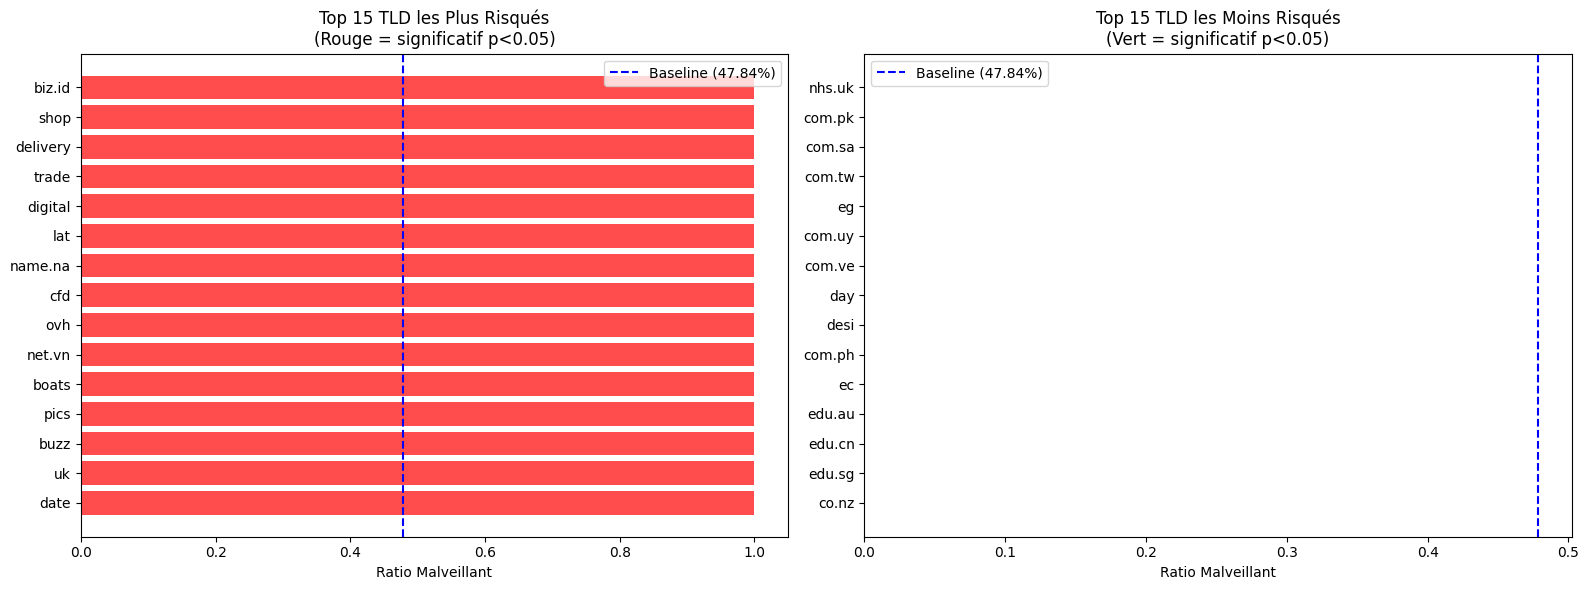


Graphique sauvegardé: tld_analysis.png


In [15]:
# Visualisation de l'analyse TLD
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 TLD les plus risqués
ax1 = axes[0]
top_risky = high_risk_tlds.head(15)
colors = ['red' if s else 'gray' for s in top_risky['significant']]
bars = ax1.barh(top_risky.index, top_risky['ratio_malicious'], color=colors, alpha=0.7)
ax1.axvline(x=df['label'].mean(), color='blue', linestyle='--', label=f'Baseline ({df["label"].mean():.2%})')
ax1.set_xlabel('Ratio Malveillant')
ax1.set_title('Top 15 TLD les Plus Risqués\n(Rouge = significatif p<0.05)')
ax1.legend()
ax1.invert_yaxis()

# Top 15 TLD les moins risqués
ax2 = axes[1]
top_safe = low_risk_tlds.head(15)
colors = ['green' if s else 'gray' for s in top_safe['significant']]
ax2.barh(top_safe.index, top_safe['ratio_malicious'], color=colors, alpha=0.7)
ax2.axvline(x=df['label'].mean(), color='blue', linestyle='--', label=f'Baseline ({df["label"].mean():.2%})')
ax2.set_xlabel('Ratio Malveillant')
ax2.set_title('Top 15 TLD les Moins Risqués\n(Vert = significatif p<0.05)')
ax2.legend()
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('tld_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nGraphique sauvegardé: tld_analysis.png")

In [17]:
ssl_analysis = analyze_categorical_feature(df, 'ssl_issuer_raw', min_samples=5)

print(f"\nBaseline (ratio malveillant global): {df['label'].mean():.2%}")
print(f"\nSSL Issuers avec le PLUS HAUT ratio de phishing:")
high_risk_ssl = ssl_analysis[
    (ssl_analysis['significant']) & 
    (ssl_analysis['ratio_malicious'] > df['label'].mean())
]
display(high_risk_ssl.head(15))

print(f"\nSSL Issuers avec le PLUS BAS ratio de phishing:")
low_risk_ssl = ssl_analysis[
    (ssl_analysis['significant']) & 
    (ssl_analysis['ratio_malicious'] < df['label'].mean())
].sort_values('ratio_malicious')
display(low_risk_ssl.head(15))


Baseline (ratio malveillant global): 47.84%

SSL Issuers avec le PLUS HAUT ratio de phishing:


,count_benign,count_malicious,total,ratio_malicious,global_ratio,diff_from_baseline,chi2,p_value,significant
ssl_issuer_raw,,,,,,,,,
"cpanel, inc.",0,101,101,1.000000,0.47844,0.521560,108.133397,2.512835e-25,True
google trust services llc,0,481,481,1.000000,0.47844,0.521560,524.826036,3.772100e-116,True
"cloudflare, inc.",30,2248,2278,0.986831,0.47844,0.508390,2413.273627,0.000000e+00,True
home.pl s.a.,8,166,174,0.954023,0.47844,0.475583,156.089558,8.092771e-36,True
google trust services,12178,21320,33498,0.636456,0.47844,0.158016,5079.063529,0.000000e+00,True
let's encrypt,10928,14861,25789,0.576253,0.47844,0.097813,1339.089117,3.619966e-293,True
globalsign nv-sa,3818,3986,7804,0.510764,0.47844,0.032324,35.347641,2.758025e-09,True



SSL Issuers avec le PLUS BAS ratio de phishing:


,count_benign,count_malicious,total,ratio_malicious,global_ratio,diff_from_baseline,chi2,p_value,significant
ssl_issuer_raw,,,,,,,,,
the trustico group ltd,26,0,26,0.0,0.47844,-0.47844,21.977472,2.758696e-06,True
valid certificadora digital ltda,18,0,18,0.0,0.47844,-0.47844,14.652870,1.292377e-04,True
"beijing xinchacha credit management co., ltd.",16,0,16,0.0,0.47844,-0.47844,12.824582,3.420950e-04,True
comodo ca limited,170,0,170,0.0,0.47844,-0.47844,154.300279,1.991161e-35,True
buypass as-983163327,20,0,20,0.0,0.47844,-0.47844,16.482624,4.909798e-05,True
cloudsecure corporation,11,0,11,0.0,0.47844,-0.47844,8.265256,4.041096e-03,True
cyber_folks s.a.,8,0,8,0.0,0.47844,-0.47844,5.546962,1.851280e-02,True
"cybertrust japan co., ltd.",184,0,184,0.0,0.47844,-0.47844,167.188407,3.042817e-38,True
d-trust gmbh,14,0,14,0.0,0.47844,-0.47844,10.998356,9.119274e-04,True


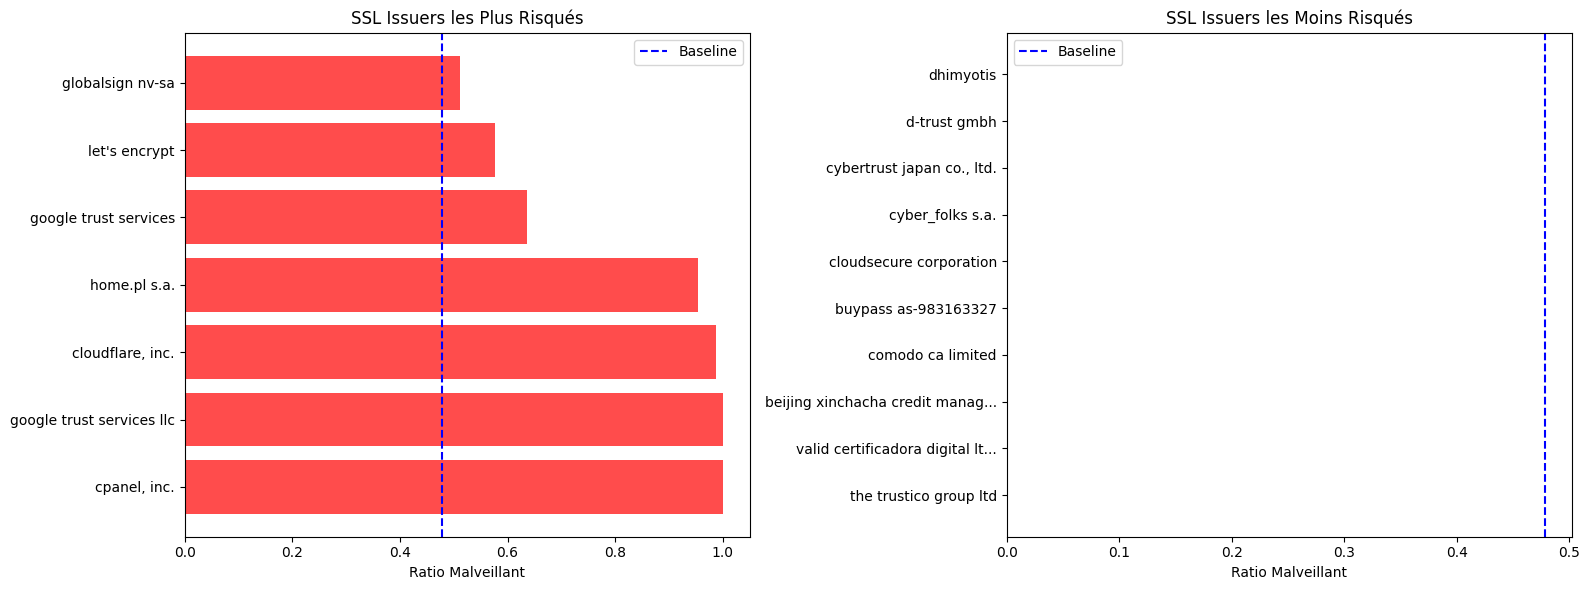

In [18]:
# Visualisation de l'analyse SSL Issuer
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top SSL risqués
ax1 = axes[0]
top_risky_ssl = high_risk_ssl.head(10)
if len(top_risky_ssl) > 0:
    ax1.barh(range(len(top_risky_ssl)), top_risky_ssl['ratio_malicious'], color='red', alpha=0.7)
    ax1.set_yticks(range(len(top_risky_ssl)))
    ax1.set_yticklabels([s[:30] + '...' if len(s) > 30 else s for s in top_risky_ssl.index])
    ax1.axvline(x=df['label'].mean(), color='blue', linestyle='--', label=f'Baseline')
ax1.set_xlabel('Ratio Malveillant')
ax1.set_title('SSL Issuers les Plus Risqués')
ax1.legend()

# Top SSL sûrs
ax2 = axes[1]
top_safe_ssl = low_risk_ssl.head(10)
if len(top_safe_ssl) > 0:
    ax2.barh(range(len(top_safe_ssl)), top_safe_ssl['ratio_malicious'], color='green', alpha=0.7)
    ax2.set_yticks(range(len(top_safe_ssl)))
    ax2.set_yticklabels([s[:30] + '...' if len(s) > 30 else s for s in top_safe_ssl.index])
    ax2.axvline(x=df['label'].mean(), color='blue', linestyle='--', label=f'Baseline')
ax2.set_xlabel('Ratio Malveillant')
ax2.set_title('SSL Issuers les Moins Risqués')
ax2.legend()

plt.tight_layout()
plt.savefig('ssl_issuer_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
# ANALYSE DES PAYS - JUSTIFICATION STATISTIQUE

country_analysis = analyze_categorical_feature(df, 'country_code_raw', min_samples=5)

print(f"\nPays avec le PLUS HAUT ratio de phishing:")
high_risk_countries = country_analysis[
    (country_analysis['significant']) & 
    (country_analysis['ratio_malicious'] > df['label'].mean())
]
display(high_risk_countries.head(15))

print(f"\nPays avec le PLUS BAS ratio de phishing:")
low_risk_countries = country_analysis[
    (country_analysis['significant']) & 
    (country_analysis['ratio_malicious'] < df['label'].mean())
].sort_values('ratio_malicious')
display(low_risk_countries.head(15))


Pays avec le PLUS HAUT ratio de phishing:


,count_benign,count_malicious,total,ratio_malicious,global_ratio,diff_from_baseline,chi2,p_value,significant
country_code_raw,,,,,,,,,
TM,0,12,12,1.000000,0.47844,0.521560,11.076221,8.744184e-04,True
MA,0,15,15,1.000000,0.47844,0.521560,14.330733,1.533409e-04,True
SC,0,122,122,1.000000,0.47844,0.521560,131.075814,2.383280e-30,True
HK,86,1284,1370,0.937226,0.47844,0.458786,1170.045783,1.973579e-256,True
BG,53,387,440,0.879545,0.47844,0.401105,283.346866,1.400461e-63,True
MY,6,37,43,0.860465,0.47844,0.382025,23.651652,1.154468e-06,True
LT,12,55,67,0.820896,0.47844,0.342455,30.151528,3.995723e-08,True
SG,469,1321,1790,0.737989,0.47844,0.259549,491.123777,8.115057e-109,True
VN,152,327,479,0.682672,0.47844,0.204232,79.637700,4.497611e-19,True



Pays avec le PLUS BAS ratio de phishing:


,count_benign,count_malicious,total,ratio_malicious,global_ratio,diff_from_baseline,chi2,p_value,significant
country_code_raw,,,,,,,,,
NZ,11,0,11,0.0,0.47844,-0.47844,8.265256,4.041096e-03,True
PK,15,0,15,0.0,0.47844,-0.47844,11.911161,5.579860e-04,True
AM,9,0,9,0.0,0.47844,-0.47844,6.450511,1.109204e-02,True
UZ,25,0,25,0.0,0.47844,-0.47844,21.061232,4.448375e-06,True
UY,9,0,9,0.0,0.47844,-0.47844,6.450511,1.109204e-02,True
MX,11,0,11,0.0,0.47844,-0.47844,8.265256,4.041096e-03,True
BY,62,0,62,0.0,0.47844,-0.47844,55.007646,1.200619e-13,True
IM,18,0,18,0.0,0.47844,-0.47844,14.652870,1.292377e-04,True
DM,14,0,14,0.0,0.47844,-0.47844,10.998356,9.119274e-04,True


## 5. Feature Engineering Justifié par les Données <a name="5-engineering"></a>

Maintenant, on crée les features catégorielles basées sur l'analyse statistique.

In [ ]:
def create_data_driven_features(df: pd.DataFrame, 
                                 tld_analysis: pd.DataFrame,
                                 ssl_analysis: pd.DataFrame,
                                 country_analysis: pd.DataFrame) -> pd.DataFrame:
    """
    Crée des features basées sur l'analyse statistique du dataset.
    Toutes les catégorisations sont JUSTIFIÉES par les données.
    """
    df_eng = df.copy()
    
    
    # 1. TLD RISQUÉ (basé sur analyse Chi-2)
    # Sélectionner les TLD significativement plus risqués que la baseline
    high_risk_tlds_set = set(tld_analysis[
        (tld_analysis['significant']) & 
        (tld_analysis['ratio_malicious'] > df['label'].mean() * 1.2)  # 20% au-dessus de la baseline
    ].index)
    
    df_eng['is_high_risk_tld'] = df_eng['tld_raw'].isin(high_risk_tlds_set).astype(int)
    print(f"TLD à haut risque identifiés: {len(high_risk_tlds_set)}")
    print(f"   Liste: {sorted(high_risk_tlds_set)[:20]}...")
    
    
    # 2. SSL ISSUER RISQUÉ (basé sur analyse Chi-2)
    high_risk_ssl_set = set(ssl_analysis[
        (ssl_analysis['significant']) & 
        (ssl_analysis['ratio_malicious'] > df['label'].mean() * 1.2)
    ].index)
    
    low_risk_ssl_set = set(ssl_analysis[
        (ssl_analysis['significant']) & 
        (ssl_analysis['ratio_malicious'] < df['label'].mean() * 0.5)  # 50% en-dessous
    ].index)
    
    df_eng['is_high_risk_ssl'] = df_eng['ssl_issuer_raw'].isin(high_risk_ssl_set).astype(int)
    df_eng['is_premium_ssl'] = df_eng['ssl_issuer_raw'].isin(low_risk_ssl_set).astype(int)
    print(f"\nSSL Issuers à haut risque: {len(high_risk_ssl_set)}")
    print(f"SSL Issuers premium: {len(low_risk_ssl_set)}")
    
    
    # 3. PAYS RISQUÉ (basé sur analyse Chi-2)
    high_risk_countries_set = set(country_analysis[
        (country_analysis['significant']) & 
        (country_analysis['ratio_malicious'] > df['label'].mean() * 1.2)
    ].index)
    
    df_eng['is_high_risk_country'] = df_eng['country_code_raw'].isin(high_risk_countries_set).astype(int)
    print(f"\nPays à haut risque: {len(high_risk_countries_set)}")
    print(f"   Liste: {sorted(high_risk_countries_set)}")
    
    
    # 4. SSL VALIDITY CATEGORY (basé sur percentiles)
    # Analyser la distribution de ssl_validity_days par classe
    benign_median = df_eng[df_eng['label'] == 0]['ssl_validity_days'].median()
    malicious_median = df_eng[df_eng['label'] == 1]['ssl_validity_days'].median()
    
    print(f"\nSSL Validity Days:")
    print(f"   Médiane bénin: {benign_median:.0f} jours")
    print(f"   Médiane malveillant: {malicious_median:.0f} jours")
    
    # Définir le seuil comme la moyenne des médianes
    threshold = (benign_median + malicious_median) / 2
    df_eng['ssl_is_short_validity'] = (df_eng['ssl_validity_days'] <= threshold).astype(int)
    print(f"   Seuil défini: {threshold:.0f} jours")
    
    
    # 5. SCORES COMBINÉS
    # DNS Trust Score
    df_eng['dns_trust_score'] = (
        df_eng['dns_ns_count'].clip(0, 5) +
        df_eng['dns_mx_count'].clip(0, 5) +
        df_eng['dns_txt_count'].clip(0, 5) +
        df_eng['dmarc_exists'] * 2
    )
    
    # Domain Maturity Score
    df_eng['domain_maturity_score'] = (
        np.log1p(df_eng['domain_age_days']) +
        df_eng['wayback_years_active'] * 0.5 +
        df_eng['has_wayback_history'] * 3
    )
    
    # URL Suspicion Score
    df_eng['url_suspicion_score'] = (
        df_eng['domain_entropy'] +
        df_eng['domain_cv_ratio'] * 0.2 +
        df_eng['subdomain_depth'] +
        df_eng['is_high_risk_tld'] * 2 +
        df_eng['has_ip_in_url'] * 5 +
        df_eng['url_at_count'] * 3
    )
    
    # SSL Trust Score
    df_eng['ssl_trust_score'] = (
        df_eng['ssl_is_valid'] +
        df_eng['is_premium_ssl'] * 2 +
        (1 - df_eng['is_high_risk_ssl']) +
        df_eng['ssl_is_wildcard'] +
        (1 - df_eng['ssl_is_short_validity'])
    )
    
    # Legitimacy Score
    df_eng['legitimacy_score'] = (
        df_eng['dns_trust_score'] +
        df_eng['ssl_trust_score'] +
        df_eng['domain_maturity_score'] -
        df_eng['url_suspicion_score']
    )
    
    
    # 6. INTERACTIONS
    df_eng['entropy_x_no_history'] = df_eng['domain_entropy'] * (1 - df_eng['has_wayback_history'])
    df_eng['risky_tld_x_risky_ssl'] = df_eng['is_high_risk_tld'] * df_eng['is_high_risk_ssl']
    df_eng['short_ssl_x_no_history'] = df_eng['ssl_is_short_validity'] * (1 - df_eng['has_wayback_history'])
    
    print(f"\nFeature Engineering terminé!")
    
    return df_eng

# Appliquer le feature engineering
df_engineered = create_data_driven_features(df, tld_analysis, ssl_analysis, country_analysis)
print(f"\nTotal features: {len(df_engineered.columns)}")

TLD à haut risque identifiés: 60
   Liste: ['app', 'asia', 'baby', 'best', 'biz.id', 'blog', 'boats', 'bond', 'buzz', 'cc', 'cfd', 'click', 'club', 'cn', 'com.ng', 'cyou', 'date', 'delivery', 'dev', 'digital']...

SSL Issuers à haut risque: 6
SSL Issuers premium: 51

Pays à haut risque: 10
   Liste: ['BG', 'HK', 'LT', 'MA', 'MY', 'SC', 'SG', 'TM', 'VN', 'ZA']

SSL Validity Days:
   Médiane bénin: 348 jours
   Médiane malveillant: 90 jours
   Seuil défini: 219 jours

Feature Engineering terminé!

Total features: 67


In [23]:
# Sauvegarder les analyses pour la documentation
print("\nTLD À HAUT RISQUE (p < 0.05, ratio > baseline + 20%):")
for tld in sorted(high_risk_tlds.head(20).index):
    row = high_risk_tlds.loc[tld]
    print(f"   .{tld}: ratio={row['ratio_malicious']:.1%}, n={row['total']:.0f}, p={row['p_value']:.2e}")

print("\nSSL ISSUERS À HAUT RISQUE:")
for issuer in high_risk_ssl.head(10).index:
    row = high_risk_ssl.loc[issuer]
    print(f"   {issuer[:40]}: ratio={row['ratio_malicious']:.1%}, n={row['total']:.0f}, p={row['p_value']:.2e}")

print("\nSSL ISSUERS PREMIUM (ratio < baseline/2):")
for issuer in low_risk_ssl.head(10).index:
    row = low_risk_ssl.loc[issuer]
    print(f"   {issuer[:40]}: ratio={row['ratio_malicious']:.1%}, n={row['total']:.0f}, p={row['p_value']:.2e}")


TLD À HAUT RISQUE (p < 0.05, ratio > baseline + 20%):
   .baby: ratio=100.0%, n=9, p=5.13e-03
   .biz.id: ratio=100.0%, n=90, p=1.08e-22
   .boats: ratio=100.0%, n=68, p=2.04e-17
   .buzz: ratio=100.0%, n=323, p=2.35e-78
   .cfd: ratio=100.0%, n=988, p=3.93e-238
   .date: ratio=100.0%, n=6, p=3.16e-02
   .delivery: ratio=100.0%, n=12, p=8.74e-04
   .digital: ratio=100.0%, n=6, p=3.16e-02
   .gd: ratio=100.0%, n=17, p=4.86e-05
   .icu: ratio=100.0%, n=351, p=4.78e-85
   .ke: ratio=100.0%, n=14, p=2.73e-04
   .lat: ratio=100.0%, n=34, p=3.27e-09
   .name.na: ratio=100.0%, n=20, p=8.75e-06
   .net.vn: ratio=100.0%, n=18, p=2.74e-05
   .ovh: ratio=100.0%, n=7, p=1.71e-02
   .pics: ratio=100.0%, n=23, p=1.59e-06
   .shop: ratio=100.0%, n=11193, p=0.00e+00
   .store: ratio=100.0%, n=47, p=2.32e-12
   .trade: ratio=100.0%, n=7, p=1.71e-02
   .uk: ratio=100.0%, n=8, p=9.34e-03

SSL ISSUERS À HAUT RISQUE:
   cpanel, inc.: ratio=100.0%, n=101, p=2.51e-25
   google trust services llc: ratio=100.

## 6. Forward Selection <a name="6-forward-selection"></a>

In [24]:
# Préparer les données pour le Forward Selection
# EXCLURE les colonnes catégorielles brutes et les identifiants
exclude_cols = ['label', 'source_file', 'tld_raw', 'ssl_issuer_raw', 'country_code_raw']
feature_cols = [col for col in df_engineered.columns if col not in exclude_cols]

X = df_engineered[feature_cols].copy()
y = df_engineered['label'].copy()

# Nettoyer
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Vérifier les features constantes
constant_features = [col for col in X.columns if X[col].nunique() <= 1]
if constant_features:
    print(f"Features constantes (supprimées): {constant_features}")
    X = X.drop(columns=constant_features)

print(f"Features pour Forward Selection: {len(X.columns)}")
print(f"Échantillons: {len(X)}")

Features constantes (supprimées): ['ssl_is_valid', 'ssl_exists', 'cookie_count']
Features pour Forward Selection: 59
Échantillons: 98470


In [25]:
# Normalisation
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 78776, Test: 19694


In [27]:
class ForwardFeatureSelector:
    """
    Forward Selection avec validation croisée.
    Principe => continue tant qu'il y a amélioration.
    """
    
    def __init__(self, estimator, cv=5, scoring='roc_auc', 
                 min_improvement=0.001, max_features=50, verbose=True):
        self.estimator = estimator
        self.cv = cv
        self.scoring = scoring
        self.min_improvement = min_improvement
        self.max_features = max_features
        self.verbose = verbose
        
        self.selected_features_ = []
        self.scores_history_ = []
    
    def fit(self, X: pd.DataFrame, y: pd.Series):
        all_features = list(X.columns)
        remaining_features = all_features.copy()
        selected_features = []
        best_score = 0
        no_improvement_count = 0
        
        if self.verbose:
            print(f" Forward Selection - {len(all_features)} features")
            print(f"   Métrique: {self.scoring}, CV: {self.cv}-fold")
            print("="*70)
        
        while remaining_features and len(selected_features) < self.max_features:
            best_feature = None
            best_new_score = best_score
            
            # Tester chaque feature restante
            for feature in tqdm(remaining_features, disable=not self.verbose,
                               desc=f"Iter {len(selected_features)+1}"):
                test_features = selected_features + [feature]
                X_subset = X[test_features]
                
                try:
                    scores = cross_val_score(self.estimator, X_subset, y,
                                           cv=self.cv, scoring=self.scoring)
                    mean_score = scores.mean()
                    
                    if mean_score > best_new_score:
                        best_new_score = mean_score
                        best_feature = feature
                except:
                    pass
            
            improvement = best_new_score - best_score
            
            if best_feature and improvement > 0:  # Amélioration > 0
                selected_features.append(best_feature)
                remaining_features.remove(best_feature)
                best_score = best_new_score
                no_improvement_count = 0
                
                self.scores_history_.append({
                    'iteration': len(selected_features),
                    'feature': best_feature,
                    'score': best_new_score,
                    'improvement': improvement
                })
                
                if self.verbose:
                    print(f"   {best_feature}: {best_new_score:.4f} (+{improvement:.4f})")
                
                # Arrêter si amélioration trop faible
                if improvement < self.min_improvement:
                    no_improvement_count += 1
                    if no_improvement_count >= 3:  # 3 itérations avec faible amélioration
                        if self.verbose:
                            print(f"\nArrêt: 3 itérations avec amélioration < {self.min_improvement}")
                        break
            else:
                if self.verbose:
                    print(f"\nArrêt: aucune amélioration possible")
                break
        
        self.selected_features_ = selected_features
        
        if self.verbose:
            print("\n" + "="*70)
            print(f"Features sélectionnées: {len(selected_features)}")
            print(f"Score final: {best_score:.4f}")
        
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return X[self.selected_features_]
    
    def get_summary(self) -> pd.DataFrame:
        return pd.DataFrame(self.scores_history_)

print("ForwardFeatureSelector défini!")

ForwardFeatureSelector défini!


In [28]:
# Exécuter le Forward Selection
# Utiliser Random Forest car moins sensible aux outliers
base_model = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                    random_state=42, n_jobs=-1)

forward_selector = ForwardFeatureSelector(
    estimator=base_model,
    cv=5,
    scoring='roc_auc',
    min_improvement=0.0005,
    max_features=40,
    verbose=True
)

forward_selector.fit(X_train, y_train)

 Forward Selection - 59 features
   Métrique: roc_auc, CV: 5-fold


Iter 1: 100%|██████████| 59/59 [02:11<00:00,  2.23s/it]


   legitimacy_score: 0.9401 (+0.9401)


Iter 2: 100%|██████████| 58/58 [03:10<00:00,  3.29s/it]


   entropy_x_no_history: 0.9774 (+0.0373)


Iter 3: 100%|██████████| 57/57 [02:49<00:00,  2.97s/it]


   dns_trust_score: 0.9881 (+0.0107)


Iter 4: 100%|██████████| 56/56 [02:54<00:00,  3.12s/it]


   asn_code: 0.9918 (+0.0037)


Iter 5: 100%|██████████| 55/55 [02:52<00:00,  3.13s/it]


   dns_total_records: 0.9928 (+0.0010)


Iter 6: 100%|██████████| 54/54 [02:47<00:00,  3.10s/it]


   url_suspicion_score: 0.9939 (+0.0011)


Iter 7: 100%|██████████| 53/53 [02:47<00:00,  3.16s/it]


   ssl_trust_score: 0.9944 (+0.0005)


Iter 8: 100%|██████████| 52/52 [02:42<00:00,  3.13s/it]


   path_length: 0.9951 (+0.0006)


Iter 9: 100%|██████████| 51/51 [02:58<00:00,  3.49s/it]


   response_count: 0.9961 (+0.0011)


Iter 10: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it]


   fqdn_length: 0.9963 (+0.0002)


Iter 11: 100%|██████████| 49/49 [02:53<00:00,  3.54s/it]


   subdomain_depth: 0.9966 (+0.0002)


Iter 12: 100%|██████████| 48/48 [02:32<00:00,  3.17s/it]


   title_length: 0.9967 (+0.0001)


Iter 13: 100%|██████████| 47/47 [02:43<00:00,  3.49s/it]


   dns_a_count: 0.9969 (+0.0002)


Iter 14: 100%|██████████| 46/46 [02:39<00:00,  3.47s/it]


   ssl_is_wildcard: 0.9970 (+0.0001)


Iter 15: 100%|██████████| 45/45 [02:34<00:00,  3.44s/it]


   dns_mx_count: 0.9970 (+0.0001)


Iter 16: 100%|██████████| 44/44 [02:41<00:00,  3.66s/it]


   has_subdomain: 0.9972 (+0.0001)


Iter 17: 100%|██████████| 43/43 [02:36<00:00,  3.64s/it]


   tld_length: 0.9972 (+0.0000)


Iter 18: 100%|██████████| 42/42 [02:31<00:00,  3.61s/it]


   url_digit_count: 0.9973 (+0.0001)


Iter 19: 100%|██████████| 41/41 [02:25<00:00,  3.55s/it]


   dmarc_exists: 0.9973 (+0.0000)


Iter 20: 100%|██████████| 40/40 [02:22<00:00,  3.55s/it]


   domain_maturity_score: 0.9973 (+0.0000)


Iter 21: 100%|██████████| 39/39 [02:17<00:00,  3.53s/it]


   dns_txt_count: 0.9974 (+0.0001)


Iter 22: 100%|██████████| 38/38 [02:14<00:00,  3.55s/it]


   tld_risk_index: 0.9975 (+0.0001)


Iter 23: 100%|██████████| 37/37 [02:10<00:00,  3.52s/it]


   har_entry_count: 0.9975 (+0.0000)


Iter 24: 100%|██████████| 36/36 [02:08<00:00,  3.57s/it]


Arrêt: aucune amélioration possible

Features sélectionnées: 23
Score final: 0.9975


Résumé du Forward Selection:


,iteration,feature,score,improvement
0,1,legitimacy_score,0.940058,0.940058
1,2,entropy_x_no_history,0.977384,0.037325
2,3,dns_trust_score,0.988102,0.010718
3,4,asn_code,0.991778,0.003676
4,5,dns_total_records,0.992790,0.001013
5,6,url_suspicion_score,0.993930,0.001140
6,7,ssl_trust_score,0.994429,0.000499
7,8,path_length,0.995068,0.000640
8,9,response_count,0.996121,0.001053
9,10,fqdn_length,0.996342,0.000221


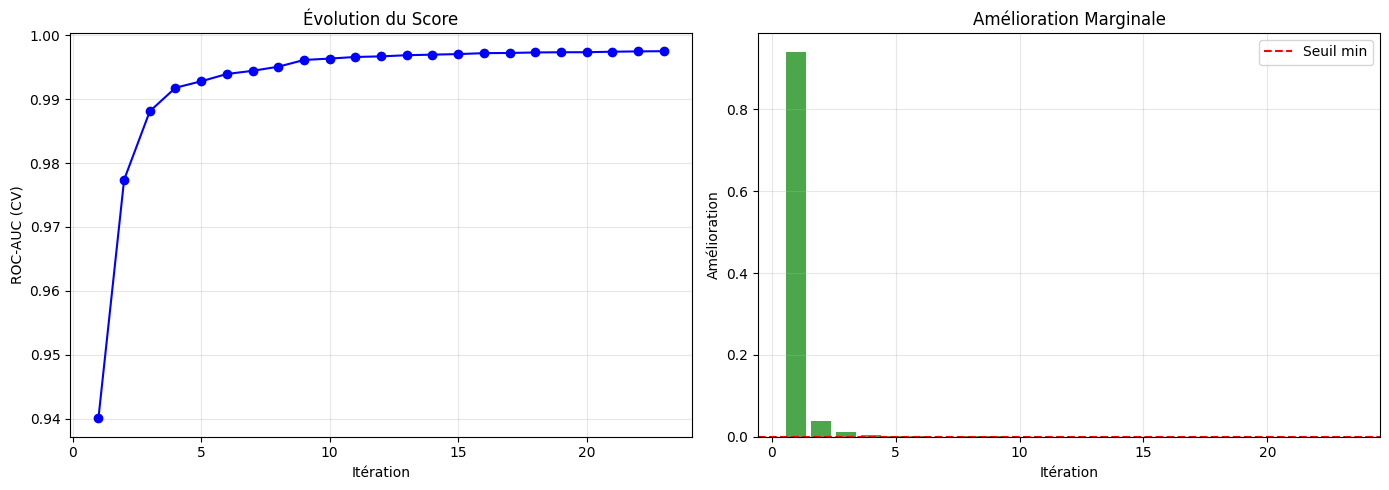

In [29]:
# Résumé de la sélection
selection_summary = forward_selector.get_summary()
selected_features = forward_selector.selected_features_

print("Résumé du Forward Selection:")
display(selection_summary)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(selection_summary['iteration'], selection_summary['score'], 'b-o')
ax1.set_xlabel('Itération')
ax1.set_ylabel('ROC-AUC (CV)')
ax1.set_title('Évolution du Score')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.bar(selection_summary['iteration'], selection_summary['improvement'], color='green', alpha=0.7)
ax2.axhline(y=0.0005, color='red', linestyle='--', label='Seuil min')
ax2.set_xlabel('Itération')
ax2.set_ylabel('Amélioration')
ax2.set_title('Amélioration Marginale')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('forward_selection.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Modélisation et Évaluation <a name="7-modelisation"></a>

In [30]:
# Préparer les données avec les features sélectionnées
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

print(f"Features sélectionnées: {len(selected_features)}")
print(f"Train: {X_train_sel.shape}, Test: {X_test_sel.shape}")

Features sélectionnées: 23
Train: (78776, 23), Test: (19694, 23)


In [31]:
# Entraîner plusieurs modèles
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=200, max_depth=10, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=200, max_depth=10, random_state=42, eval_metric='logloss')
}

results = []

for name, model in models.items():
    print(f"\n{name}...")
    
    cv_scores = cross_val_score(model, X_train_sel, y_train, cv=5, scoring='roc_auc')
    model.fit(X_train_sel, y_train)
    
    y_pred = model.predict(X_test_sel)
    y_proba = model.predict_proba(X_test_sel)[:, 1]
    
    results.append({
        'Model': name,
        'CV ROC-AUC': f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}",
        'Test ROC-AUC': roc_auc_score(y_test, y_proba),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Test Precision': precision_score(y_test, y_pred),
        'Test Recall': recall_score(y_test, y_pred),
        'Test F1': f1_score(y_test, y_pred),
        'Test PR-AUC': average_precision_score(y_test, y_proba)
    })
    
    print(f"   CV: {cv_scores.mean():.4f}, Test ROC-AUC: {results[-1]['Test ROC-AUC']:.4f}")

results_df = pd.DataFrame(results).sort_values('Test ROC-AUC', ascending=False)

print("RÉSULTATS")
display(results_df)


Logistic Regression...
   CV: 0.9828, Test ROC-AUC: 0.9824

Random Forest...
   CV: 0.9991, Test ROC-AUC: 0.9990

Gradient Boosting...
   CV: 0.9988, Test ROC-AUC: 0.9985

LightGBM...
   CV: 0.9992, Test ROC-AUC: 0.9990

XGBoost...
   CV: 0.9994, Test ROC-AUC: 0.9993
RÉSULTATS


,Model,CV ROC-AUC,Test ROC-AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test PR-AUC
4,XGBoost,0.9994 ± 0.0001,0.999311,0.991926,0.993711,0.989387,0.991544,0.999348
3,LightGBM,0.9992 ± 0.0001,0.999026,0.988372,0.989980,0.985672,0.987821,0.999058
1,Random Forest,0.9991 ± 0.0001,0.998981,0.986849,0.989424,0.983018,0.986211,0.999024
2,Gradient Boosting,0.9988 ± 0.0001,0.998537,0.984818,0.986352,0.981851,0.984097,0.998586
0,Logistic Regression,0.9828 ± 0.0010,0.982395,0.941403,0.938667,0.938866,0.938767,0.982393


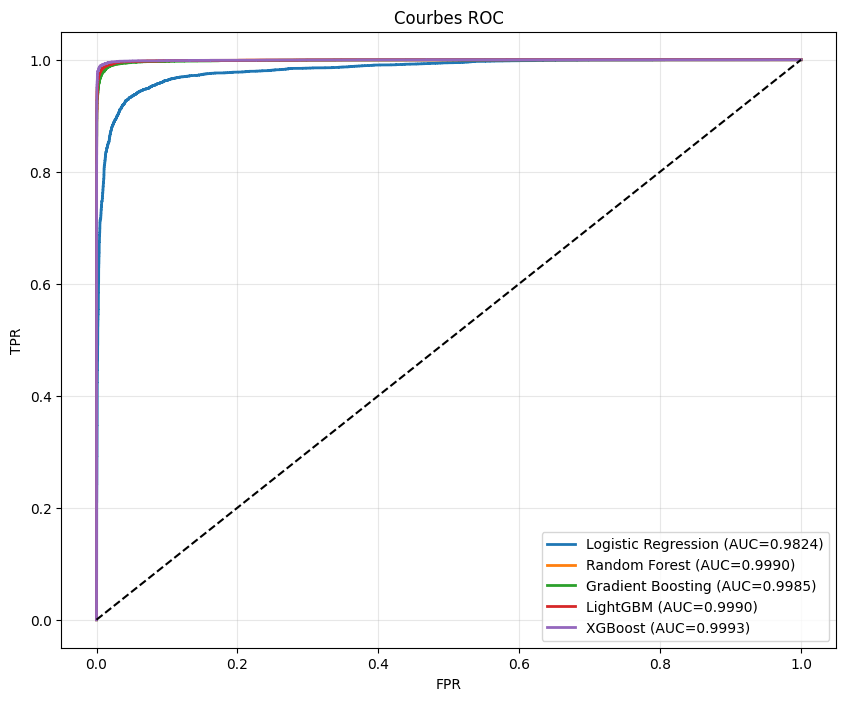

In [32]:
# Courbes ROC
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_proba = model.predict_proba(X_test_sel)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Courbes ROC')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

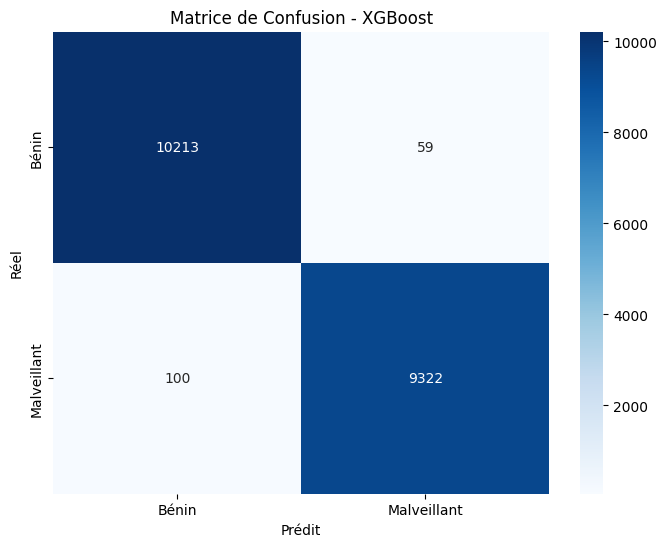


Meilleur modèle: XGBoost
              precision    recall  f1-score   support

       Bénin       0.99      0.99      0.99     10272
 Malveillant       0.99      0.99      0.99      9422

    accuracy                           0.99     19694
   macro avg       0.99      0.99      0.99     19694
weighted avg       0.99      0.99      0.99     19694



In [33]:
# Meilleur modèle - Matrice de confusion
best_name = results_df.iloc[0]['Model']
best_model = models[best_name]

y_pred_best = best_model.predict(X_test_sel)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bénin', 'Malveillant'],
            yticklabels=['Bénin', 'Malveillant'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title(f'Matrice de Confusion - {best_name}')
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMeilleur modèle: {best_name}")
print(classification_report(y_test, y_pred_best, target_names=['Bénin', 'Malveillant']))

## 8. Analyse des Résultats <a name="8-analyse"></a>

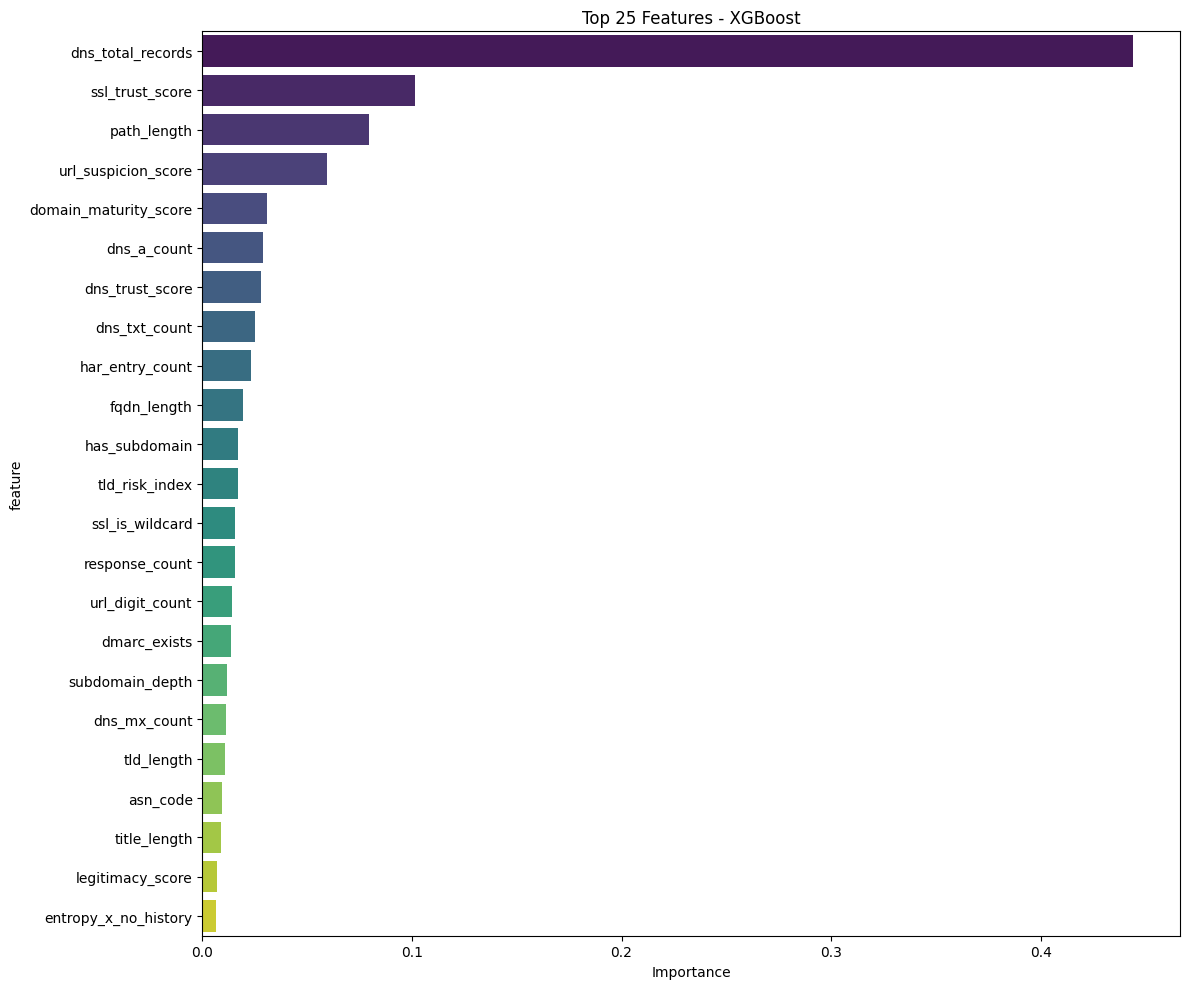


Top 15 Features:


,feature,importance
4,dns_total_records,0.444281
6,ssl_trust_score,0.101685
7,path_length,0.079445
5,url_suspicion_score,0.059613
19,domain_maturity_score,0.031003
12,dns_a_count,0.029097
2,dns_trust_score,0.027864
20,dns_txt_count,0.025080
22,har_entry_count,0.023405
9,fqdn_length,0.019478


In [34]:
# Importance des features
if hasattr(best_model, 'feature_importances_'):
    feat_imp = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 10))
    sns.barplot(data=feat_imp.head(25), x='importance', y='feature', palette='viridis')
    plt.title(f'Top 25 Features - {best_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nTop 15 Features:")
    display(feat_imp.head(15))